In [65]:
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

import h5py
import scipy.signal
import logging
import time

from lisagwresponse import GalacticBinary
from lisainstrument import Instrument

from pytdi import Data
from pytdi import michelson as mich
from pytdi import ortho

from astropy.io import ascii
from astropy.table import Table, Column, MaskedColumn
from astropy import units as u
from astropy.coordinates import SkyCoord
from astropy.coordinates import BarycentricMeanEcliptic

import os

In [75]:
# orbit_path = '../orbits/keplerianupsampled.h5'
# orbit_path = '../orbits/kep-1hz30d.h5'
orbit_path = '../orbits/keplerian_long.h5'
gw_path = 'gws.h5'

# Setup simluation parameters
fs = 0.1    # Hz
day = 86400 # s
duration = day*1 # X days
size = duration*fs
discard = 300

rec = ['A','E','T']

with h5py.File(orbit_path) as orbits:
    orbits_t0 = orbits.attrs['t0']
    orbit_fs = 1/orbits.attrs['dt']
    orbit_dur = orbits.attrs['tsize']/orbit_fs
    print ("fs = "+str(fs)+" Hz,  orbit_duration = "+str(orbit_dur/day)+" d")


# Turn on/off binary creation & instrument simulation
use_verbinaries = True
run_new_simulation = True

# Specify specific number of binaries
Ngalbins = 8

fs = 0.1 Hz,  orbit_duration = 1500.0 d


In [76]:
# Insert binary parameters
amplitude_amplification = 1

if use_verbinaries:
    # Define name of simulation uitput file
    sample_outputf = 'measurements/MCMCsample'+str(int(duration))+'s'+'_verbins' #extention of .h5 or .txt added later
    
    rawdata = ascii.read("verbinaries_data_wsource_name.txt")
    
    params = ['lGal', 'bGal', 'orbital_period', 'm1', 'm1e', 'm2', 'm2e', 'i', 'freq', 'par','epar', 'dis', 'edis', 'A', 'eA', 'SNR', 'eSNR']
    # units: lGal [deg], bGal [deg], orbital_period [s], m1 [Msol], m1e [Msol], m2 [Msol], m2e [Msol]
    # i [deg], freq (of gws) [mHz], par [mas], epar [mas], dis [pc], edis [pc], A [1e-23], eA [1e-23], SNR, eSNR
    
    sourcenames = np.array(rawdata["source"])[:Ngalbins]
    Amp_true = (np.array(rawdata["A"])* (1e-23 * amplitude_amplification))[:Ngalbins] # 10yokto to 1e-23 
    f_true = (np.array(rawdata["freq"])* (1e-3))[:Ngalbins] # mHz to Hz
    iota = np.deg2rad(np.array(rawdata["i"]))[:Ngalbins] # deg to rad
    
    # Galactic coordinates of verification binaries   
    source_gal_lon = np.array(rawdata["lGal"])[:Ngalbins]  # degree range from [0,360]
    source_gal_lat = np.array(rawdata["bGal"])[:Ngalbins]  # degree range from [-90,90]

    # Transform coordinates to (barycentric mean) ecliptic coordinates
    gc = SkyCoord(l=source_gal_lon*u.degree, b=source_gal_lat*u.degree, frame='galactic')
    gw_beta_true = np.deg2rad(gc.barycentricmeanecliptic.lon.value)[:Ngalbins] # degree to rad range [0,2pi]
    gw_lambda_true = np.deg2rad(gc.barycentricmeanecliptic.lat.value)[:Ngalbins] # degree to rad range [-pi/2,pi/2]

    # Transform coordinates to equatoral (ICRS) coordinates
    # ra = gc.icrs.ra.value # degree range [0,360]
    # dec = gc.icrs.dec.value # degree range [-90,90]
    
    totNgalbins = len(sourcenames)
    phi0_true_forinst = np.zeros(Ngalbins)[:Ngalbins]
    phi0_true = np.array(ascii.read("verbinaries_phaseoffset.txt")['phi0'])[:Ngalbins]
    print ("Number of Verification Binaries = {}".format(Ngalbins))

else:
    # Define name of simulation uitput file
    sample_outputf = 'measurements/MCMCsample'+str(int(duration))+'s' #extention of .h5 or .txt added later
    
    Ngalbins = 2
    Amp_true = [1e-16,5e-13]
    f_true = [1e-3,1e-4]
    phi0_true = [0,0]
    gw_beta_true = [0,0]
    gw_lambda_true = [0,np.pi]


Number of Verification Binaries = 8


In [77]:
# Setup galactic binary to insert in simulation
if run_new_simulation:
    if os.path.exists(gw_path):
        os.remove(gw_path)
    
    for a,f,p,beta,lamb in zip(Amp_true, f_true, phi0_true, gw_beta_true, gw_lambda_true):
        source = GalacticBinary(A=a, f=f, phi0=p, orbits=orbit_path ,t0=orbits_t0 + 10, gw_beta=beta, gw_lambda=lamb, dt=1/fs, size=size+300)
        source.write(gw_path)
    #source = GalacticBinary(A=6.4e-23, f=6.22e-3, orbits=orbit_path, t0=orbits_t0+10, gw_beta=0,gw_lambda=0) #HM Cnc
    #source = GalacticBinary(A=5E-20, f=1E-2, orbits=orbit_path ,t0=orbits_t0 + 10, gw_beta=0, gw_lambda=0)
    #source = GalacticBinary(A=1E-16, f=1E-2, orbits=orbit_path ,t0=orbits_t0 + 10, gw_beta=0, gw_lambda=0) #ridiculously loud binary


In [78]:
# Create 'realistic' orbit with signal and noise
if run_new_simulation:
    # Setup logger (sometimes useful to follow what's happening)
    # logging.basicConfig()
    # logging.getLogger('lisainstrument').setLevel(logging.INFO)
    
    t0 = time.time()
    sample_instru = Instrument(
        size=size, # in samples
        dt=1/fs,
        aafilter=('kaiser', 240, 0.275*fs, 0.725*fs),
        orbits=orbit_path, # realistic orbits (make sure it's consistent with glitches and GWs!)
        gws=gw_path
    )
    sample_instru.disable_all_noises()
    sample_instru.simulate()
    
    
    # Write out data to sample file, NOTE: Remember to remove the old sample file.
    if os.path.exists(sample_outputf+'.h5'):
        os.remove(sample_outputf+'.h5')
    sample_instru.write(sample_outputf+'.h5')
    
    print ("Time to run simulation = "+str(time.time()-t0))
    
    # Read data from LISA Instrument
    rawdata = Data.from_instrument(sample_outputf+'.h5')
    
    t0 = time.time()
    A = ortho.A2.build(**rawdata.args)(rawdata.measurements)[discard:]
    t1 = time.time()
    print ("Time to build and run A2 = "+str(t1-t0))
    E = ortho.E2.build(**rawdata.args)(rawdata.measurements)[discard:]
    t2 = time.time()
    print ("Time to build and run E2 = "+str(t2-t1))
    T = ortho.T2.build(**rawdata.args)(rawdata.measurements)[discard:]
    t3 = time.time()
    print ("Time to build and run T2 = "+str(t3-t2))

    #t = sample_instru.t[discard:]
    t = (np.arange(0,len(A)+discard)/fs)[discard:]

    sdata = np.array([t,A,E,T])

    # Extract A, E, T data to speed up re-running code.
    filepath = sample_outputf+'.txt'
    filecontent = Table(sdata.T, names=['t','A','E','T'])
    ascii.write(filecontent, filepath, overwrite=True)

    t4 = time.time()
    print ("Total time = "+str(t4-t0))

Time to run simulation = 1.3262355327606201
Time to build and run A2 = 3.5148632526397705
Time to build and run E2 = 4.775850296020508
Time to build and run T2 = 5.050719738006592
Total time = 13.384958744049072


In [79]:
# Retreive A, E, T data
rawdata = ascii.read(sample_outputf+'.txt')
sdata = np.array([rawdata['t'],rawdata['A'],rawdata['E'],rawdata['T']])

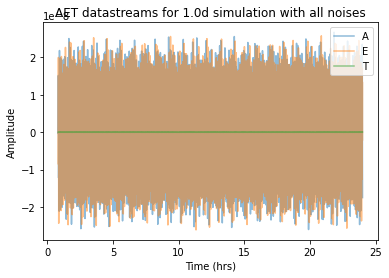

In [80]:
for i in range(3):
    plt.plot(sdata[0]/3600,sdata[i+1],label=rec[i],alpha=.5)
plt.title('AET datastreams for '+str(duration/day)+'d simulation with all noises')
plt.legend()
plt.xlabel('Time (hrs)')
plt.ylabel('Amplitude')
plt.show()

[[0.00000000e+00 1.19904077e-05 2.39808153e-05 ... 4.99760192e-02
  4.99880096e-02 5.00000000e-02]
 [2.71099193e-24 5.42222572e-24 5.42295098e-24 ... 1.06770519e-25
  1.06681435e-25 5.33663059e-26]
 [1.36294903e-27 2.89630644e-27 3.40758591e-27 ... 2.92880633e-25
  2.92774741e-25 1.46406432e-25]
 [2.23705954e-29 4.47429875e-29 4.47483821e-29 ... 1.25664415e-30
  1.85402190e-30 7.65792740e-31]]
(4, 4171)


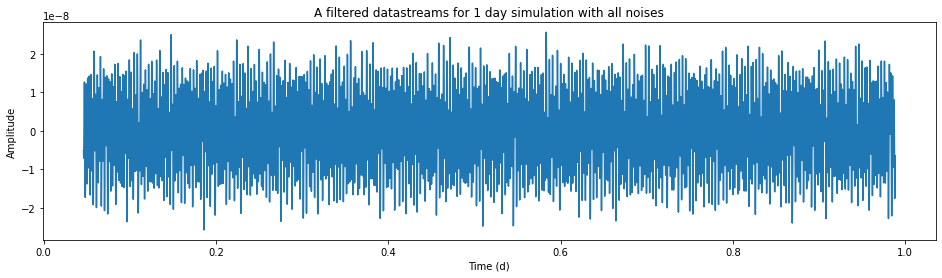

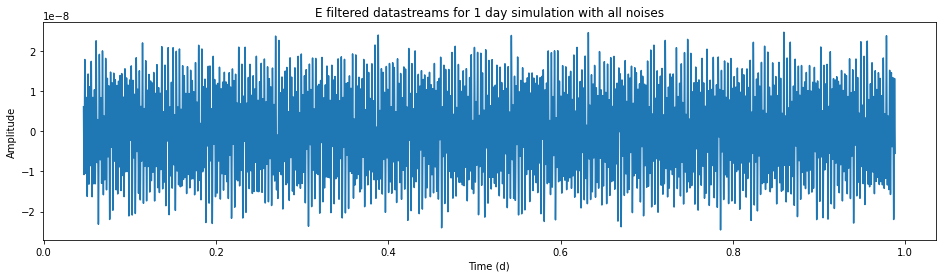

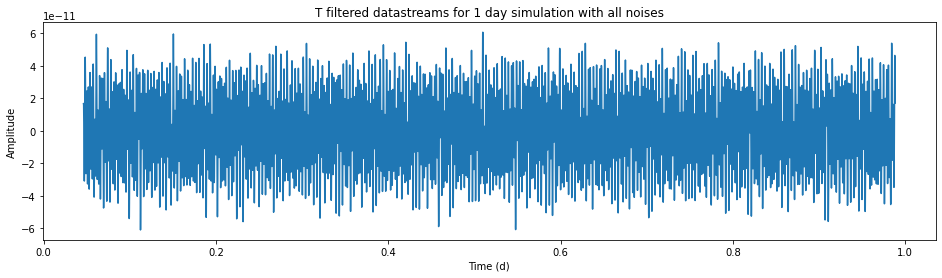

In [70]:
def psd_func(data):
    return scipy.signal.welch(data,fs=fs,window='nuttall',nperseg=len(data),detrend=False)

# Create psd for data
tmp = []
for i in range(1,4):
    ftmp, psdtmp = psd_func(sdata[i])
    tmp.append(psdtmp)
psd = np.array([ftmp,tmp[0],tmp[1],tmp[2]])

# Create filtered data
cutoff = 100
tmp = []
#coeffs = scipy.signal.firls(73,bands=[0,1,1.2,2],desired=[1,1,0,0],fs=fs)
#coeffs = scipy.signal.firls(73, bands=[0,1e-2,3e-2,5e-2], desired=[1,1,0,0],fs=fs)
coeffs = scipy.signal.firls(73, bands=[0,5e-3,1e-2,fs/2], desired=[1,1,0,0],fs=fs)
for i in range(1,4):
    fdata_tmp = scipy.signal.filtfilt(coeffs,1., x=sdata[i],padlen=len(psd[0]))
    tmp.append(fdata_tmp[cutoff:-cutoff])
fsdata = np.array([sdata[0][cutoff:-cutoff],tmp[0],tmp[1],tmp[2]])

# Create psd for filtered data
tmp = []
for i in range(1,4):
    ftmp, psdtmp = psd_func(fsdata[i])
    tmp.append(psdtmp)
fpsd = np.array([ftmp,tmp[0],tmp[1],tmp[2]])

for i in range(3):
    plt.figure(figsize=(16,4))
    plt.plot(fsdata[0]/day,fsdata[i+1])
    plt.title(rec[i]+' filtered datastreams for 1 day simulation with all noises')
    plt.xlabel('Time (d)')
    plt.ylabel('Amplitude')
    #plt.xlim(.25,1)
    plt.show()

In [74]:
print (psd.shape)
print (len(sdata[0])//2)

(4, 4171)
4170


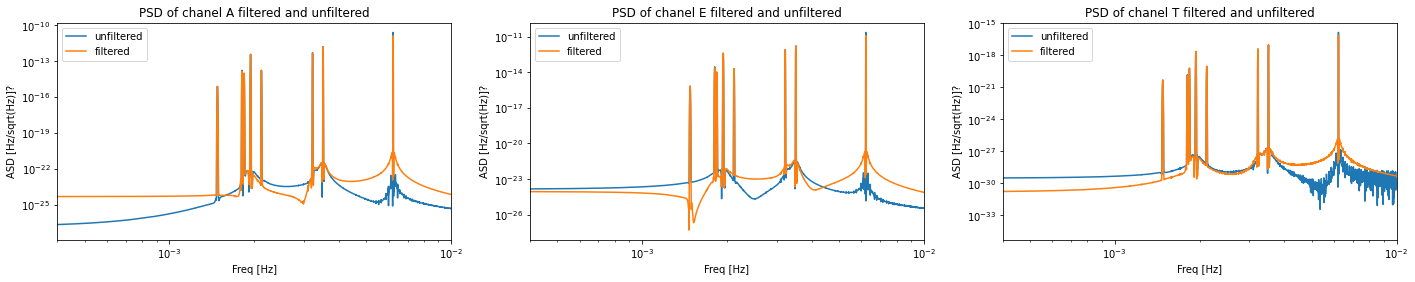

In [39]:
fig, axs = plt.subplots(1,3)
fig.set_figheight(4)
fig.set_figwidth(24)
for i in range(3):
    axs[i].plot(psd[0],psd[i+1], label='unfiltered')
    axs[i].plot(fpsd[0],fpsd[i+1], label='filtered')
    axs[i].legend()
    axs[i].set_yscale('log')
    axs[i].set_xscale('log')
    axs[i].set_xlabel('Freq [Hz]')
    axs[i].set_ylabel('ASD [Hz/sqrt(Hz)]?')
    axs[i].set_title("PSD of chanel "+rec[i]+' filtered and unfiltered')
    axs[i].set_xlim(4e-4,1e-2)
plt.show()

In [19]:
# Difference factor between pytdi.Data.from_instrument and pytdi.Data.from_gws

def dphi_to_dnu(time,data):
    laser_freq = 2.816E14 #Hz, gotten from lisainstrument code
    dt = 1/fs
    # dt = np.mean((time[1:]-time[:-1]))
    return np.diff(data) * ((laser_freq) / (2*np.pi*dt))

# Building The Galactic Binary MCMC fit
Here is a list of things that can be done to speed up the model simulation function:
1) Stop exporting and importing GalBin data and simulated data, but directly input them in functions
2) Improve the AET calculation times & simulation setup times (takes 4s)
3) Decrease sampling rate of LISA instrument
4) 

In [43]:
# Generate random binary to be able to build the TDI chanels
time_elapsed = []
time_elapsed.append(time.time())

for a, f, p, beta, lamb in zip(Amp_true, f_true, phi0_true, gw_beta_true, gw_lambda_true):
    GalBin = GalacticBinary(A=a/f, f=f, phi0=p, orbits=orbit_path, t0=orbits_t0+10, gw_beta=beta, gw_lambda=lamb, dt=1/fs, size=size+300)
    # Amplitude is a/f since we have to convert from_gws to from_instr by differentiating and don't want extra factors of 2pi*f
    GalBin.write('gw_tmp.h5')

time_elapsed.append(time.time()) 
rawdata = Data.from_gws('gw_tmp.h5',orbit_path,interpolate=True)#, skipped=-int(size))
time_elapsed.append(time.time())

Afunc = ortho.A2.build(**rawdata.args)
time_elapsed.append(time.time())
A = Afunc(rawdata.measurements)[discard:]
time_elapsed.append(time.time())

tmp = np.array(time_elapsed)[1:] - np.array(time_elapsed[:-1])
print ("gw_gen = {:.3f}, signal_gen = {:.3f}, TDIbuild = {:.3f}, TDIcalc = {:.3f}, Total = {:.3f}".format(*tmp,time_elapsed[-1]-time_elapsed[0]))

t = GalBin.t[discard:]
# t = model_instru.t[discard:]
# t = (np.arange(0,len(A)+discard)/4)[discard:]
mdata = np.array([t,A])

os.remove('gw_tmp.h5')


# Without interpolate, for 30 days it takes 7s, with interpolate it takes 0.66s
#but it takes 1.8s to generate the GW's as apposed to 0.68s

gw_gen = 0.755, signal_gen = 0.177, TDIbuild = 2.281, TDIcalc = 0.086, Total = 3.300


(34560,) (34560,)


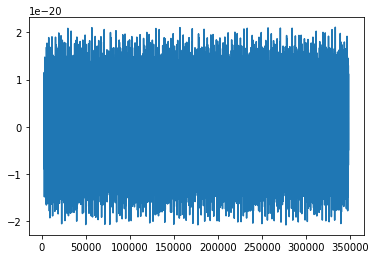

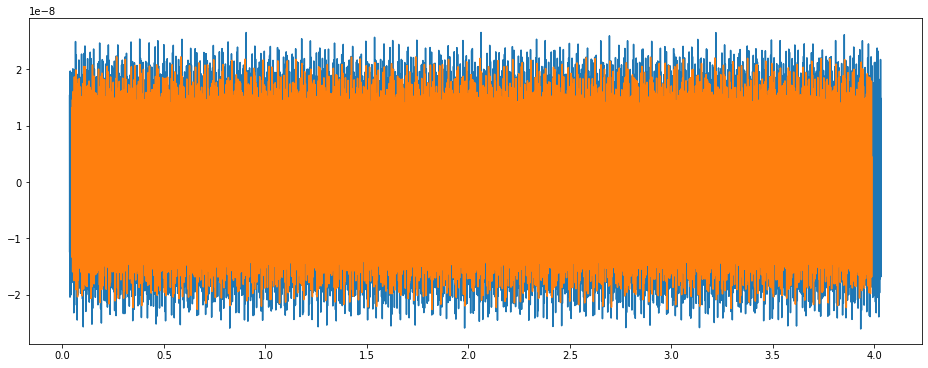

In [44]:
print (t.shape,A.shape)
plt.plot(t,A)
plt.show()
plt.figure(figsize=(16,6))
plt.plot(t[:-1]/day,dphi_to_dnu(t,A))
plt.plot(fsdata[0]/day,fsdata[1])
#plt.xlim(0.2,0.25)
plt.show()

# MCMC on the data

In [45]:
# Defining the model used for MCMC fitting

def model(st,sA, theta, gw_beta=gw_beta_true, gw_lambda=gw_lambda_true, t0=orbits_t0+10):
    
    Amp, phi0 = theta[0:Ngalbins], theta[Ngalbins:2*Ngalbins]
    
    # Generate GW signals
    for a, f, p, beta, lamb in zip(Amp, f_true, phi0, gw_beta, gw_lambda):
        GalBin = GalacticBinary(A=a/f, f=f, phi0=p, orbits=orbit_path, t0=t0, gw_beta=beta, gw_lambda=lamb, dt=1/fs, size=size+300)
        # Amplitude is a/f since we have to convert from_gws to from_instr by differentiating and don't want extra factors of 2pi*f
        GalBin.write('gw_tmp.h5')
    
    # rawdata = Data.from_gws( 'gw_tmp.h5', orbit_path)
    rawdata = Data.from_gws('gw_tmp.h5', orbit_path,interpolate=True)
    mA = Afunc(rawdata.measurements)[discard:]
    #E = Efunc(rawdata.measurements)[discard:]
    # If we only fit signal parameters, we don't include T since it has by definition no signal.
    #T = Tfunc(rawdata.measurements)[discard:]
    
    mt = GalBin.t[discard:]
    
    os.remove('gw_tmp.h5')
    
    # Generate correct amplitude to be compatible with sample data
    nmt = np.copy(mt)[:-1]
    nmA = dphi_to_dnu(mt,mA)
    
    # Make sure that the model generates data at the correct time
    time_indices = np.where(np.in1d(nmt, st))[0]
    nnmt, nnmA = nmt[time_indices], nmA[time_indices]

    return np.array([nnmt,nnmA])
    # return np.array([t,A,E,T])

Time elapsed = 1.01
(4, 34060)
(2, 34060)


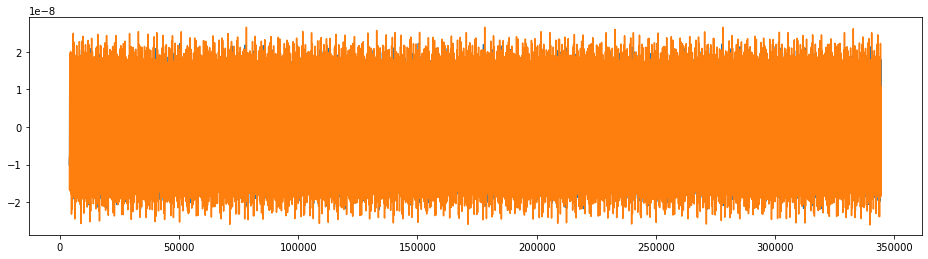

In [46]:
script_time0 = time.time()

test = model(fsdata[0],fsdata[1],[*Amp_true,*phi0_true],gw_beta_true,gw_lambda_true)

script_time1 = time.time() - script_time0
print ("Time elapsed = {:.2f}".format(script_time1))


plt.figure(figsize=(16,4))
plt.plot(fsdata[0],fsdata[1])
plt.plot(test[0],test[1])
# plt.xlim(1e4,1.1e4)
plt.plot()
print (fsdata.shape)
print (test.shape)

In [47]:
# Define functions needed for mcmc fitting
import emcee
from tqdm import tqdm

# Guesses
Amp_guess, f_guess, phi0_guess = Amp_true, f_true, phi0_true
#phi0_guess = phi0_true #rad
#theta_guess = np.array([Amp_guess, f_guess])

theta_guess = np.array([Amp_guess,f_guess,phi0_guess])
theta_true = np.array([Amp_true,f_true,phi0_true])


# Coding gaussian prior
def gauss_prior(arr, sig, mu):
    gauss = np.exp(-((arr-mu)**2)/(2*(sig**2)))
    return np.log(gauss)#/(np.sqrt(2*np.pi*(sig)**2))) so gaussian is not normalised so peak is at 1 (log peak at 0)

# Setting up the priors is [observed quantity, error in quantity]
Amp_prior = Amp_guess*np.array([[1]*Ngalbins,[0.01]*Ngalbins])

# # Plotting amplitude and frequency prior to see if all went well
# for i, xlab in zip(range(4),["Amplitude","Frequency [Hz]"]):
#     x = [np.linspace(1e-18,1e-16,1000),np.linspace(5e-4,5e-3,1000)]
#     plt.plot(x[i],gauss_prior(x[i],obs_q[i]*obs_qe[i],obs_q[i]))
#     plt.plot([x[i][0],x[i][-1]],[0,0],c='black',linestyle='dashed')
#     plt.xlabel(xlab)
#     plt.show()

def lnL(theta, t, y):
    """
    The log likelihood of our simplistic Linear Regression. 
    """
    # Amp, f, phi0 = theta
    newt, y_model = model(t,y,theta)
    
    return -0.5*(np.sum((y-y_model)**2))

def lnprior(theta):
    """
    Define a gaussian prior that preferences values near the observed values of the Galactic binaries     
    """
    Amp, phi0 = theta[:Ngalbins], theta[Ngalbins:2*Ngalbins]
    
    # if 1e-18 < Amp < 1e-14:
    #     return gauss_prior(f, obs_q[1]*obs_qe[1],obs_q[1])
    # return -np.inf
    if int(np.sum((-np.pi <= phi0) * (phi0 <= np.pi))) == Ngalbins:
        return np.sum(gauss_prior(Amp,Amp_prior[1],Amp_prior[0])) #gauss_prior(Amp, obs_q[0]*obs_qe[0], obs_q[0]) + gauss_prior(f, obs_q[1]*obs_qe[1],obs_q[1])
    return -np.inf
    
def lnprob(theta, t, y):
    """
    The likelihood to include in the MCMC.
    """
    lp = lnprior(theta)
    if not np.isfinite(lp):
        return -np.inf
    return lp+lnL(theta, t, y)


In [48]:
# Set up the properties of the problem.
ndim, nwalkers = int(2*Ngalbins), 100

# My guess at a solution
print ("A_true = {}, f_true = {}, phi0 = {}".format(Amp_true,f_true,phi0_true))


A_true = [6.40e-23 1.10e-22 1.07e-22 6.20e-23 2.83e-22 6.10e-23 1.75e-22 3.20e-23], f_true = [0.00622 0.00351 0.00322 0.00212 0.00194 0.00184 0.00181 0.00148], phi0 = [0. 0. 0. 0. 0. 0. 0. 0.]


In [49]:
# Give the walkers all a slightly different starting position 
#such that they will walk different paths

# pos_Amp = Amp_guess + 0.01*Amp_guess*np.random.randn(nwalkers)
# pos_f = f_guess + 0.01*f_guess*np.random.randn(nwalkers)
pos_Amp = np.zeros((Ngalbins,nwalkers))
pos_phi0 = np.zeros((Ngalbins,nwalkers))
for i in range(Ngalbins):
    pos_Amp[i] = Amp_guess[i] * (1 + 0.001*np.random.randn(nwalkers))
    pos_phi0[i] = phi0_guess[i] + 0.1*np.random.randn(nwalkers)

# pos = np.array([pos_Amp,pos_f]).T
pos = np.array([*pos_Amp,*pos_phi0]).T
# pos = np.array([theta_guess + 1e-4*np.random.randn(ndim) for i in range(nwalkers)])
print (pos.shape)
# print (pos)

# pos = [theta_guess + 1e-4*np.random.randn(ndim) for i in range(nwalkers)]

(100, 16)


In [50]:
# We can now run emcee by setting up a sampler

sampler = emcee.EnsembleSampler(nwalkers, ndim, lnprob, args=(fsdata[0], fsdata[1]))

# Determines how many steps the walkers take. Usually the first 25/50 steps have to be neglected
MCMC_steps = 250

In [51]:
# Run sampler for MCMC_steps steps, now with progress bar :)

t0 = time.time()
for pos,lnp,rstate in tqdm(sampler.sample(pos, iterations=MCMC_steps)):
    pass
t1 = time.time()-t0

print ("Time elapsed wfilt = {:.2f}".format(t1))


1it [03:38, 218.09s/it]Traceback (most recent call last):
  File "/home/bart/Desktop/lisa/venv-lisa/lib/python3.8/site-packages/emcee/ensemble.py", line 624, in __call__
    return self.f(x, *self.args, **self.kwargs)
  File "/tmp/ipykernel_22158/2331827068.py", line 59, in lnprob
    return lp+lnL(theta, t, y)
  File "/tmp/ipykernel_22158/2331827068.py", line 35, in lnL
    newt, y_model = model(t,y,theta)
  File "/tmp/ipykernel_22158/661527403.py", line 11, in model
    GalBin.write('gw_tmp.h5')
  File "/home/bart/Desktop/lisa/venv-lisa/lib/python3.8/site-packages/lisagwresponse/core.py", line 173, in write
    response = self.compute_gw_response(self.LINKS, t)
  File "/home/bart/Desktop/lisa/venv-lisa/lib/python3.8/site-packages/lisagwresponse/core.py", line 450, in compute_gw_response
    xicross = 2 * dot(n, self.u) * dot(n, self.v) # (link, t)
  File "/home/bart/Desktop/lisa/venv-lisa/lib/python3.8/site-packages/lisagwresponse/utils.py", line 17, in dot
    return numpy.einsum('i

emcee: Exception while calling your likelihood function:
  params: [ 6.40578723e-23  1.10647740e-22  1.06861678e-22  6.23934139e-23
  2.83202946e-22  6.12273735e-23  1.74604218e-22  3.21156513e-23
 -1.32401210e-01 -2.21435321e-04 -1.53328584e-01  3.54514897e-01
 -1.64515270e-01  4.44157904e-01 -9.03399724e-02  1.50968546e-01]
  args: (array([  4000.,   4010.,   4020., ..., 344570., 344580., 344590.]), array([-8.60842879e-09, -1.02705149e-08, -1.00453871e-08, ...,
       -4.40509356e-09,  4.02100989e-10,  4.43896715e-09]))
  kwargs: {}
  exception:


KeyboardInterrupt: 

In [ ]:
# Run sampler for MCMC_steps steps (10walkers 150 steps took 16.5 minutes)

# t0 = time.time()
# tmp2 = sampler.run_mcmc(pos,MCMC_steps)
# t1 = time.time() - t0
# print ("Time elapsed wfilt = {:.2f}".format(t1))

In [52]:
# Now comes analysing the output
print (sampler.chain.shape)

# print (sampler.chain[:,:,0])

# print (np.array(phi0_values).reshape(nwalkers,MCMC_steps))

(100, 1, 16)


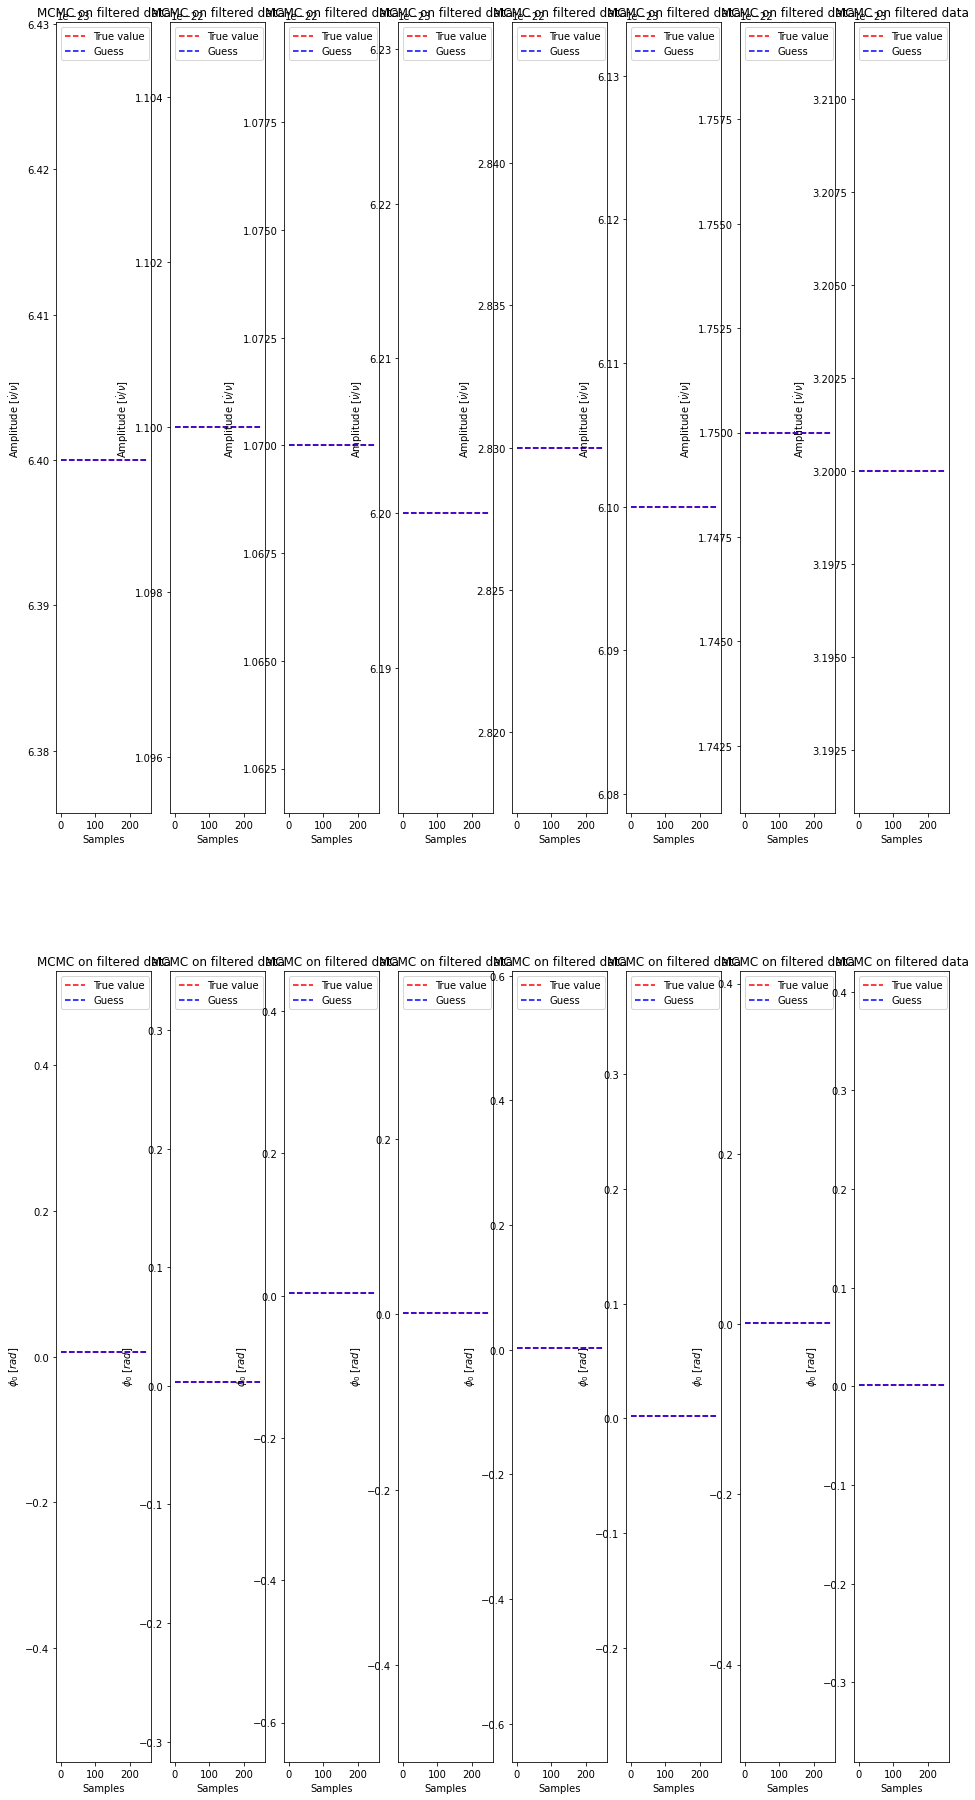

In [53]:
# Plot the result

fig,axs = plt.subplots(ndim//Ngalbins,Ngalbins, figsize=(16,int(2*ndim)))
for j,ylab in zip(range(ndim),["Amplitude $[\dot{\\nu}/\\nu]$", '$\phi_0\ [rad]$']):
    for i in range(Ngalbins):
        axs[j,i].plot(sampler.chain[:,:,j*Ngalbins+i].transpose(), color='black', alpha=0.3)
        axs[j,i].plot([0,MCMC_steps],[theta_true[j,i]]*2,c='red',linestyle='dashed',label='True value')
        axs[j,i].plot([0,MCMC_steps],[theta_guess[j,i]]*2,c='blue',linestyle='dashed',label='Guess')
        axs[j,i].set_title("MCMC on filtered data")
        axs[j,i].set_ylabel(ylab)
        axs[j,i].legend()
        axs[j,i].set_xlabel('Samples')
        #plt.yscale('log')
        #plt.ylim(0.9*np.min(sampler.chain[:,:,i]),1.1*np.max(sampler.chain[:,:,i]))
plt.show()


# plt.hist(phi0_values,bins=100)
# plt.xlabel("Phase offset [rad]")
# plt.ylabel("number of values")
# plt.yscale('log')
# plt.show()


# Extract MCMC data to speed up re-running code.
for j,par in zip(range(ndim),["A","phi0"]):
    for i in range(Ngalbins):
        filepath = 'measurements/MCMCfit'+par+str(i)+'.txt'
        filecontent = Table(sampler.chain[:,:,j*Ngalbins+i].transpose(), names=['w'+ str(w) for w in range(nwalkers) ])
        ascii.write(filecontent, filepath, overwrite=True)

In [ ]:
# After X samples, the mcmc stabalises so we cut away the part before that 
mcmc_cutoff = 0

tmp0 = []
tmp0_cut = []
for j,par in zip(range(ndim),["A","phi0"]):
    for i in range(Ngalbins):
        filepath = 'measurements/MCMCfit'+par+str(i)+'.txt'
        tmp1 = []
        tmp2 = ascii.read(filepath)
        for w in range(nwalkers):
            tmp1.append(tmp2['w'+str(w)])
        tmp0.append(np.array(tmp1).T)
        tmp0_cut.append((np.array(tmp1).T)[:, mcmc_cutoff:].reshape((-1, 1))[:,0])
samples = np.array(tmp0)
samples_cut = np.array(tmp0_cut)


#samples_nfilt_cut = sampler_nfilt.chain[:, mcmc_cutoff:, :].reshape((-1, 1))[:,0]
# samples_wfilt_cut = sampler_wfilt.chain[:, mcmc_cutoff:, :].reshape((-1, 1))[:,0]
print (samples.shape)
print (samples_cut.shape)
print (samples_cut)

In [ ]:

fig,axs = plt.subplots(ndim//Ngalbins,Ngalbins, figsize=(16,int(2*ndim)))
for j,ylab in zip(range(ndim),["Amplitude $[\dot{\\nu}/\\nu]$", '$\phi_0\ [rad]$']):
    for i in range(Ngalbins):
        axs[j,i].plot(samples[j*Ngalbins+i], color='black', alpha=0.3)
        axs[j,i].plot([cutoff]*2, [-1e20,1e20],c='red',linestyle='dashed',linewidth=1,label='MCMC cutoff')
        # axs[j,i].plot([0,MCMC_steps],[theta_true[j,i]]*2,c='red',linestyle='dashed',label='True value')
        axs[j,i].plot([0,MCMC_steps],[theta_guess[j,i]]*2,c='blue',linestyle='dashed',label='Guess')
        axs[j,i].set_title("MCMC on filtered data")
        axs[j,i].set_ylabel(ylab)
        axs[j,i].set_ylim(0.995*np.min(samples[j*Ngalbins+i]),1.005*np.max(samples[j*Ngalbins+i]))
        axs[j,i].legend()
        axs[j,i].set_xlabel('Samples')
        #plt.yscale('log')
        #plt.ylim(0.9*np.min(sampler.chain[:,:,i]),1.1*np.max(sampler.chain[:,:,i]))
plt.show()


In [ ]:
import corner
print (samples_cut.shape)

# fig = corner.corner(np.array([np.log10(samples_cut[0]),np.log10(samples_cut[1])]).T,labels=["$A$", "$f$"],\
#                     truths=[np.log10(theta_true[0]),np.log10(theta_true[1])])#, quantiles=[0.16, 0.5, 0.84], show_titles=True)
# fig = corner.corner(samples_cut.T,labels=["$A_1$", "$A_2$", "$\phi_{0,0}$","$\phi_{0,1}$"],truths=[*theta_true[0],*theta_true[1]],\
#                         quantiles=[0.16, 0.5, 0.84], show_titles=True)

for i in range(Ngalbins):
    corner.corner(samples_cut[i::ndim//Ngalbins].T,labels=["$A$","$\phi_0$"],truths=[theta_true[0][i],theta_true[1][i]],\
                        quantiles=[0.16, 0.5, 0.84], show_titles=True)